In [1]:
import tensorflow as tf  # Import TensorFlow for building and training models
from tensorflow.keras.optimizers import Adam, SGD  # Import optimizers for model training
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy  # Import loss functions
from tensorflow.keras.metrics import SparseCategoricalAccuracy, CategoricalAccuracy  # Import metrics for evaluation
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping  # Import callbacks for training
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Import image data generator for augmentation
import matplotlib.pyplot as plt  # Import matplotlib for plotting graphs
#from model import CNNModel  # Import custom CNN model class from model module
import kagglehub  # Import Kaggle Hub for dataset management
import numpy as np  # Import NumPy for numerical operations
import random  # Import random for sampling
import numpy as np  # Import NumPy for numerical operations
import matplotlib.pyplot as plt  # Import matplotlib for plotting graphs
from tensorflow.keras.models import load_model  # Import load_model to load the trained model
import random  # Import random for random sampling
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, Activation, MaxPooling2D,Dropout, GlobalAveragePooling2D, Dense)  # Import necessary layers from Keras
from tensorflow.keras.models import Model  # Import Model class to create the model

In [2]:
#Initialize the CNN model parameters.
class CNNModel:
    def __init__(self, input_shape=(48, 48, 1), num_classes=7):

        self.input_shape = input_shape  # Set the input shape
        self.num_classes = num_classes  # Set the number of classes

    #A convolutional block consisting of Conv2D, BatchNormalization, Activation, MaxPooling2D, and Dropout.
    def _conv_block(self, x, filters, kernel_size, pool_size, dropout_rate):
        for filter_size in filters:  # Iterate through the filter sizes
            x = Conv2D(filter_size, kernel_size, padding='same', activation='relu')(x)  # Apply Conv2D
            x = BatchNormalization()(x)  # Apply Batch Normalization
        x = MaxPooling2D(pool_size=pool_size)(x)  # Apply MaxPooling
        x = Dropout(dropout_rate)(x)  # Apply Dropout for regularization
        return x  # Return the output tensor

    #Build the CNN model architecture.
    def build_model(self):

        inputs = Input(shape=self.input_shape)  # Define the input layer

        # Convolutional Blocks
        x = self._conv_block(inputs, filters=[64, 64], kernel_size=(3, 3), pool_size=(2, 2), dropout_rate=0.25)  # First conv block
        x = self._conv_block(x, filters=[128, 128], kernel_size=(3, 3), pool_size=(2, 2), dropout_rate=0.35)  # Second conv block
        x = self._conv_block(x, filters=[256, 256], kernel_size=(3, 3), pool_size=(2, 2), dropout_rate=0.45)  # Third conv block

        # Global Average Pooling
        x = GlobalAveragePooling2D()(x)  # Apply Global Average Pooling

        # Fully Connected Layers
        x = Dense(128, activation='relu')(x)  # First Dense Layer
        x = BatchNormalization()(x)  # Apply Batch Normalization
        x = Dropout(0.5)(x)  # Apply Dropout

        # Output Layer
        outputs = Dense(self.num_classes, activation='softmax')(x)  # Output layer with softmax activation

        model = Model(inputs=inputs, outputs=outputs)  # Create the Keras Model
        return model  # Return the model

In [3]:
# Download latest version of the dataset
dataset_path = kagglehub.dataset_download("msambare/fer2013")  # Download dataset
print("Path to dataset files:", dataset_path)  # Print dataset path

100%|██████████| 60.3M/60.3M [00:00<00:00, 126MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/msambare/fer2013/versions/1


In [5]:
# Image data generators for augmentation and normalization
train_data_gen = ImageDataGenerator(rescale=1./255, rotation_range=10,  # Rescale and augment training data
    zoom_range=0.2,  # Random zoom
    width_shift_range=0.1,  # Random width shift
    height_shift_range=0.1,  # Random height shift
    horizontal_flip=True,  # Random horizontal flip
    fill_mode='nearest',  # Fill mode for new pixels
    validation_split=0.2)  # Split for validation

# Define train and validation data generators
train_generator = train_data_gen.flow_from_directory(
    '/root/.cache/kagglehub/datasets/msambare/fer2013/versions/1/train',  # Path to training data
    target_size=(48, 48),  # Resize images to 48x48
    batch_size=64,  # Set batch size
    class_mode='categorical',  # Set class mode for multi-class
    color_mode="grayscale",  # Use grayscale images
    subset='training',  # Use training subset
    shuffle=True  # Shuffle data
)

val_generator = train_data_gen.flow_from_directory(
    '/root/.cache/kagglehub/datasets/msambare/fer2013/versions/1/train',  # Same path for validation
    target_size=(48, 48),  # Resize images to 48x48
    batch_size=64,  # Set batch size
    class_mode='categorical',  # Set class mode for multi-class
    color_mode="grayscale",  # Use grayscale images
    subset='validation',  # Use validation subset
    shuffle=True  # Shuffle data
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.


In [6]:
# Instantiate the model
cnn_model = CNNModel(input_shape=(48, 48, 1), num_classes=7)
emotion_model = cnn_model.build_model()

# Compile the model
emotion_model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Set optimizer with learning rate
    loss=CategoricalCrossentropy(from_logits=True),  # Set loss function
    metrics=[CategoricalAccuracy ()]  # Set evaluation metric
)

# Callbacks for saving the model and early stopping
checkpoint_callback = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_categorical_accuracy')  # Save best model
early_stopping_callback = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0.01, patience=15, restore_best_weights=True, mode='auto')  # Early stopping

# Train the model
training_history = emotion_model.fit(
    train_generator,  # Training data
    validation_data=val_generator,  # Validation data
    epochs=50,  # Number of epochs
    callbacks=[checkpoint_callback, early_stopping_callback]  # Callbacks
)

# Evaluate the model on validation data
print('Training finished')  # Indicate training completion


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:593: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 52s 106ms/step - categorical_accuracy: 0.1689 - loss: 2.5369 - val_categorical_accuracy: 0.1620 - val_loss: 2.1983
Epoch 2/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 27s 73ms/step - categorical_accuracy: 0.2009 - loss: 2.2844 - val_categorical_accuracy: 0.2515 - val_loss: 2.2081
Epoch 3/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 42s 75ms/step - categorical_accuracy: 0.2264 - loss: 2.1715 - val_categorical_accuracy: 0.2670 - val_loss: 1.9194
Epoch 4/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 40s 74ms/step - categorical_accuracy: 0.2550 - loss: 2.0639 - val_categorical_accuracy: 0.2998 - val_loss: 1.8074
Epoch 5/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 40s 72ms/step - categorical_accuracy: 0.2803 - loss: 1.9802 - val_categorical_accuracy: 0.3440 - val_loss: 1.7021
Epoch 6/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 26s 72ms/step - categorical_accuracy: 0.3139 - loss: 1.8716 - val_categorical_accuracy: 0.3611 - val_loss: 1.7685
Epoch 7/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 41s 73ms/step - categorical_accuracy: 0.3507 -

Train Loss: 1.0175288915634155
Train Accuracy: 0.6190351843833923
Validation Loss: 1.0195857286453247
Validation Accuracy: 0.6214945316314697


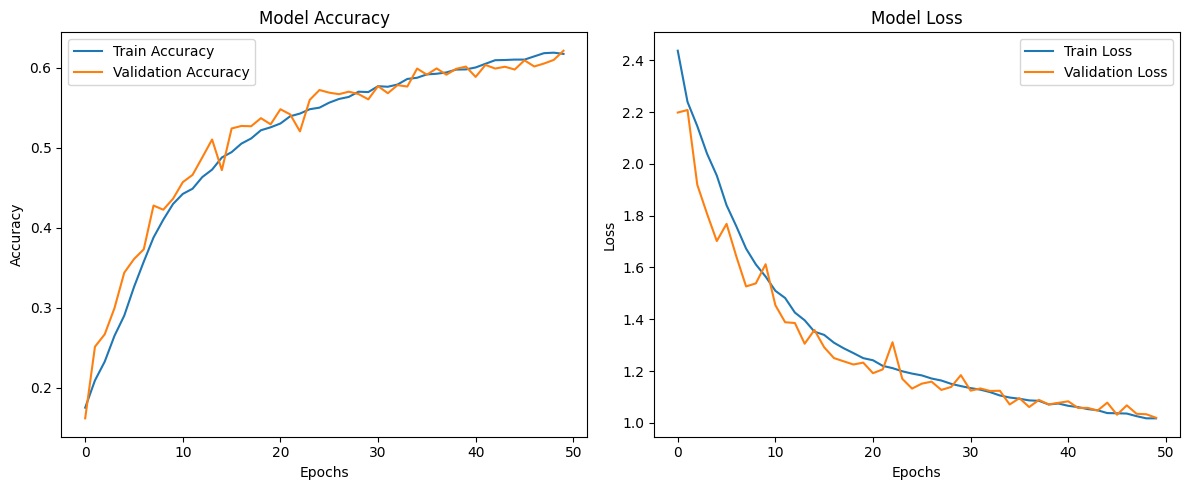

In [9]:
# Get the best training accuracy and corresponding loss
best_training_accuracy = max(training_history.history['categorical_accuracy'])  # Find the maximum training accuracy
best_training_accuracy_epoch = training_history.history['categorical_accuracy'].index(best_training_accuracy) + 1  # Get the epoch index for the best training accuracy
best_training_loss = training_history.history['loss'][best_training_accuracy_epoch - 1]  # Get the corresponding training loss

# Get the best validation accuracy and corresponding loss
best_validation_accuracy = max(training_history.history['val_categorical_accuracy'])  # Find the maximum validation accuracy
best_validation_accuracy_epoch = training_history.history['val_categorical_accuracy'].index(best_validation_accuracy) + 1  # Get the epoch index for the best validation accuracy
best_validation_loss = training_history.history['val_loss'][best_validation_accuracy_epoch - 1]  # Get the corresponding validation loss

# Print the best training and validation metrics
print(f"Train Loss: {best_training_loss}")  # Print the best training loss
print(f"Train Accuracy: {best_training_accuracy}")  # Print the best training accuracy
print(f"Validation Loss: {best_validation_loss}")  # Print the best validation loss
print(f"Validation Accuracy: {best_validation_accuracy}")  # Print the best validation accuracy

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))  # Set the figure size for the plots

# Accuracy plot
plt.subplot(1, 2, 1)  # Create a subplot for accuracy
plt.plot(training_history.history['categorical_accuracy'], label='Train Accuracy')  # Plot training accuracy
plt.plot(training_history.history['val_categorical_accuracy'], label='Validation Accuracy')  # Plot validation accuracy
plt.title('Model Accuracy')  # Set the title for the accuracy plot
plt.xlabel('Epochs')  # Set the x-axis label
plt.ylabel('Accuracy')  # Set the y-axis label
plt.legend()  # Show the legend

# Loss plot
plt.subplot(1, 2, 2)  # Create a subplot for loss
plt.plot(training_history.history['loss'], label='Train Loss')  # Plot training loss
plt.plot(training_history.history['val_loss'], label='Validation Loss')  # Plot validation loss
plt.title('Model Loss')  # Set the title for the loss plot
plt.xlabel('Epochs')  # Set the x-axis label
plt.ylabel('Loss')  # Set the y-axis label
plt.legend()  # Show the legend

plt.tight_layout()  # Adjust the layout to prevent overlap
plt.show()  # Display the plots

Found 7178 images belonging to 7 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - categorical_accuracy: 0.5617 - loss: 1.1459
Test Loss: 1.0056159496307373
Test Accuracy: 0.6264976263046265


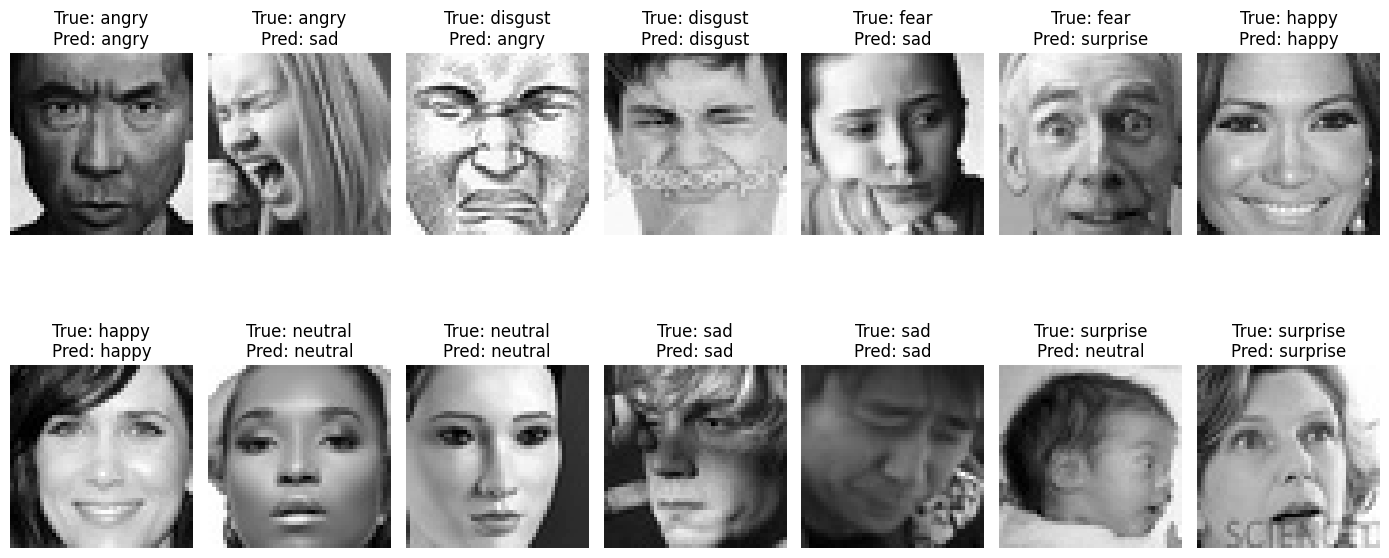

In [11]:
# Path to the test dataset
test_directory = "/root/.cache/kagglehub/datasets/msambare/fer2013/versions/1/test"  # Define the path to the test data

# Test data generator with rescaling
test_data_generator = ImageDataGenerator(rescale=1.0 / 255)  # Create an instance of ImageDataGenerator for test data

# Generate test data (don't shuffle since we want to pick specific images)
test_generator = test_data_generator.flow_from_directory(
    test_directory,  # Path to the test directory
    target_size=(48, 48),  # Resize images to 48x48
    color_mode="grayscale",  # Read images in grayscale
    class_mode="categorical",  # Use categorical labels for multi-class classification
    batch_size=64,  # Set batch size to 64
    shuffle=False  # Important: we need to know the order of images
)

# Load the trained model (assuming it's saved as 'best_model.keras')
trained_model = load_model("best_model.keras")  # Load the trained model from file

# Get the class labels from the generator
class_labels = list(test_generator.class_indices.keys())  # Retrieve class labels from the generator

# Lists to store the selected images, their true labels, and predictions
selected_images = []  # Initialize list to store selected images
selected_labels = []  # Initialize list to store true labels
selected_predictions = []  # Initialize list to store predicted labels

# Randomly select 2 images per class
for class_name in class_labels:  # Iterate through each class label
    # Get the indices of images belonging to the current class
    class_indices = [i for i, label in enumerate(test_generator.classes) if test_generator.class_indices[class_name] == label]  # Get indices for the current class

    # Randomly select 2 indices from the class
    selected_indices = random.sample(class_indices, 2)  # Randomly select 2 indices

    # Fetch images and make predictions
    for idx in selected_indices:  # Iterate through the selected indices
        # Get the batch that contains the image at the selected index
        batch_index = idx // test_generator.batch_size  # Calculate the batch index
        batch_images, batch_labels = test_generator[batch_index]  # Get the batch of images and labels

        # Get the specific image from the batch
        image = batch_images[idx % test_generator.batch_size]  # Get the specific image
        label = test_generator.classes[idx]  # Get the true label for the image

        # Make prediction for the selected image
        image_expanded = np.expand_dims(image, axis=0)  # Add batch dimension to the image
        prediction = trained_model.predict(image_expanded)  # Make prediction for the image
        predicted_class = class_labels[np.argmax(prediction)]  # Get the predicted class label

        # Store the image, true label, and predicted label
        selected_images.append(image)  # Append the image to the list
        selected_labels.append(class_labels[label])  # Append the true label to the list
        selected_predictions.append(predicted_class)  # Append the predicted class to the list

# Evaluate the model on the test data
test_loss, test_accuracy = trained_model.evaluate(test_generator)  # Evaluate the model on the test dataset
print(f"Test Loss: {test_loss}")  # Print the test loss
print(f"Test Accuracy: {test_accuracy}")  # Print the test accuracy

# Display the selected images with their labels and predictions
plt.figure(figsize=(14, 10))  # Set the figure size for the plot
for i in range(14):  # Iterate through the selected images
    plt.subplot(3, 7, i + 1)  # Create a subplot for each image
    plt.imshow(selected_images[i].reshape(48, 48), cmap='gray')  # Display the image in grayscale
    plt.title(f"True: {selected_labels[i]}\nPred: {selected_predictions[i]}")  # Set the title with true and predicted labels
    plt.axis('off')  # Hide the axes for a cleaner look

plt.tight_layout()  # Adjust the layout to prevent overlap
plt.show()  # Display the plot